
# DR oxygen analysis

Weronika Biela-Nowaczyk

2024

In [1]:
import numpy as np
import re
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.optimize import minimize_scalar
from scipy.special import wofz
from scipy.optimize import leastsq
%matplotlib inline

In [2]:
# Constants
RCATH=0.002            # Cathode radius [m]
RTUBE=0.05             # Tube radius [m]
EXP_FACTOR=33                # Adiabatic beam EXP_FACTORansion factor
MASS_ION= 14899168637  #14896453700  #14896453700   # ion mass [eV/c²] -> oxygen BUT! find better
u = 931494102.42       #eV/c^2
MASS_ION_AMU=15.99491461956   # ion mass [amu]
ETA=0.014807#   0.020303     #   # COOL_LENGTH/CIRC
COOL_LENGTH=0.9        # Cooler interaction zone length [m]; assume error of 1 cm
CIRC=54.029            # Ring orbit [m]; error ca. 12.5 cm assuming the orbit might be 2 cm further out or in
F_REV =810033          # revolution frequency [Hz] from Beamcalc

#determine/estimate appropriate error values
# RCATH_ERROR=0.0002   #10%
# RTUBE_ERROR=0.0001   #1/10 of a mm machining tolerance
# ECOOL_ERROR=1.0      #based on RR symmetrization
# ECUR_ERROR=0.0002    #10%
# EXP_FACTOR_ERROR=0.1        #no idea
# ETA_ERROR=0.00023    #see assumptions for COOL_LENGTH and CIRC above
# F_REV_ERROR=2500

# Fundamental constants. 
C_LIGHT=299792458              # Speed of light [m/s]
ELEM_CHARGE=1.60217653e-19     # Elementary charge [C]
AMU=931.494102e6               # eV
AMU_KG=1.66053886e-27          # Atomic mass [kg]
MASS_E=510998.950              # Electron mass [eV x c²], CODATA2018
MASS_E_KG=9.1093826e-31        # Electron mass [kg]
BOLTZMANN=8.617343e-5          # [eV/K]
BOLTZMANN_J=BOLTZMANN*ELEM_CHARGE              # [J/K]
# ALPHA=7.297352568e-3            # ~1/137
# G_E=2.0231930436                # g-Factor electron (CODATA)
EPSILON_0=8.854187817e-12       # C/Vm
# MU_0=4.*np.pi*1e-7                 # permeability of free space, (N*A^2) SI units.
RYDBERG_CONST=13.6056923        # eV



# data paths

exp_data_path ='./data/exp/'
theory_data_path ='./data/theory/'

# for smoothen G35 value of smoothing 
SMOOTH_dict = {"01":25000,
                "03": 160,
               "04": 478, 
               "05": 180,
               "06": 750,
               "07": 430,
               "08":400,#350,
               "09": 8500,
               "11": 1300,#1080, 
               "12": 67,
               "22":90,
               "13":235}

#translation to fit to RAMP13
TRANSLATION_dict = { "01" : 0,
                "03": 0,#-0.584756,
                "04": 0,# 0.140271,
                "05": 0,#0.015850158501584888,#0.205312, 
                "06": 0,#-0.315073,
                "07": 0,#-1,
                "08": 0,#-0.326453,
                "09": 0,#-0.83992,
                "11": 0,#-0.810618,
                "12": 0,#-0.315073,
                "22": 0,#-0.315073,    
                "13": 0}

#error from smoothen G35 if energy from Schottky
ERROR_dict= {
        '03' : 0.4271392822265625/2,
        '04' : 0.6035442352294922/2,
        '05' : 0.8025779724121094/2,
        '06' : 0.6848011016845703/2,
        '07' : 0.8128738403320312/2, #here we have a different distance between KLL main peaks
        '08' : 0.8881206512451172/2,
        '09' : 3.493885040283203/2,
        '11' : 1.5224647521972656/2,
        '12' : 0.7375679016113281/2,
        '22' : 0.505218505859375/2,
        '13' : 0.570159912109375/2}




# CryringData Class 

In [3]:

class CryringData:
    def __init__(self, filename):
        self.name = filename[18:20]    # Extract the substring containing the desired name
        self.prepare_data(filename)

    
    def prepare_data(self, filename):
        myvars = {}
        with open(filename) as myfile:
            for cnt in range(88):
                line = next(myfile)
                if ':' in line:
                    name, var = line.partition(':')[::2]
                    name = name.strip().strip('#')
                    var = var.strip()
                    myvars[name.strip()] = var                
            header_line = next(myfile)
        
        #Values useful for me from header
        try: #for FC and RF 
            self.e_curr = float(myvars['electron current (mA)'])*0.001
        except KeyError:
            if self.name == "04":
                self.e_curr = 21*0.001
            else:
                self.e_curr = 19.47*0.001
        try:
            self.main_pow_supply = float(myvars['cath meas voltage (V)'])
        
        except KeyError:
            if self.name == "01":
                self.main_pow_supply = 5580.5 
            elif self.name == "03" or self.name == "04":
                self.main_pow_supply = 3500
            else:
                self.main_pow_supply = 3000
        
        self.cooling_energy = float(myvars['cooling energy (eV)']) #this is not the best chice- it is a set value- better from shotky
#         try: 
#             self.ion_energy = float(myvars['ion energy (MeV/u)'])
#         except KeyError:
#             if self.name == "01" or self.name == "03" or self.name == "04":
#                 self.ion_energy = 10.1417
#             else:
#                 self.ion_energy = 10.144
        if self.name == "01" or self.name == "03" or self.name == "04":
            self.ion_energy = 10.103383559619909  #based on Schottky signal
        else:
            self.ion_energy = 10.105674869970947
        #self.header_keys = myvars.keys()
        #self.header_values = myvars.values()
        
        #Labels give the labels for each array in self.data
        header_line = header_line.strip('#')
        header_line = re.split(r'\[\d+\]', header_line)
        self.labels = header_line
        #MAsk data where there is an missaligment
        if self.name == "06":
            start_row = 134 #89 row of "preambule" +no. of rows to delete
            self.data = np.genfromtxt(filename, delimiter=',', usecols=range(0, 41, 1), dtype=float, skip_header=start_row)
        elif self.name == "13":
            start_row = 300
            self.data = np.genfromtxt(filename, delimiter=',', usecols=range(0, 41, 1), dtype=float, skip_header=start_row)
        
        else:
            self.data = np.genfromtxt(filename, delimiter=',',usecols=range(0, 41, 1),dtype=float)
         
    

    
    ############################################################################
    #
    #    Electron-ion energy
    #
    ############################################################################
    



    def smoothen_G35(self, added_value=0):
        """
        To analyse the differences between different ramps in correction of energy (Uset(Arnold))
        """
        value=SMOOTH_dict[self.name]
       
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        x = self.data[:,0]
        y = self.data[:,13] #Arnold
        spl = UnivariateSpline(x, y, s=value)
        y_fit = spl(x)*slope+intercept #G35
        correction = np.mean(y_fit-y)
        return y_fit-correction+added_value+TRANSLATION_dict[self.name]
    
    
    def error_smoothen_G35(self):
        x = self.data[:,0]
        y = self.data[:,13] #Arnold
        return np.abs(self.smoothen_G35()-y)
    
    def ElabtoEsc(self, Elab):
        """
        Performs space-charge correction on lab energy values
        Esther
        """
        SC = 0
        Eold, Enew, ne, acc1, acc, eps, factor = 0, 0, 0, 0, 1.0, 0.0000001, 0
        i, maxiter, sign = 0, 100, 0
        factor = ELEM_CHARGE*RCATH*RCATH*EXP_FACTOR/(4*EPSILON_0) * (1 + 2*np.log(RTUBE/(RCATH*np.sqrt(EXP_FACTOR))))
        while np.all(acc > eps) and i < maxiter:
            Eold = Enew
            Enew = Elab - SC
            ne = self.Edensity(Elab)
            SC = ne * factor
            acc1 = Eold / Enew - 1
            sign = np.where(acc1 > 0, 1, -1)
            acc = sign * acc1
            i += 1
        return Enew
    
    def EsctoEcm(self, Esc, correction_RR=0):
        """
        Performs transformation of (space-charge corrected) lab energy to centre-of-mass energy
        Esther
        """
        Correction_RR =15.056565656565656 #BASED on possition of RR peak 
        Ecool = self.ElabtoEsc(self.cooling_energy+Correction_RR+correction_RR)
#         Ecool = self.ElabtoEsc(self.cooling_energy+step)
        Ei = Ecool * MASS_ION / MASS_E
        sign = np.ones_like(Esc)
        sign[Esc > Ecool] = 1
        sign[Esc <= Ecool] = -1

        aa = MASS_ION + MASS_E
        sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
        sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
        bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte

        Ec = sign * (np.sqrt(aa*aa + 2 * bb) - aa)
        return Ec
    
        
################################################################################
        
    def calibration_NEW2(self, correction_RR=0):
        """
        Performs calibration for energy
        with correction at smoothen_G35()
            x = self.data[:,0]
            y = self.data[:,13] #Arnold
            spl = UnivariateSpline(x, y, s=value)
            y_fit = spl(x)*slope+intercept #G35
            correction = np.mean(y_fit-y)
        """
        return np.abs(self.EsctoEcm(self.ElabtoEsc(self.smoothen_G35()), correction_RR))
        
    def error_calibration_NEW2(self, step=0):
        """
        Performs calibration for energy
        """
        return np.abs(self.EsctoEcm(self.ElabtoEsc(self.smoothen_G35()), step)- self.EsctoEcm(self.ElabtoEsc(self.smoothen_G35(ERROR_dict[self.name])), step))

    

    def calibration_LAB(self,correction_RR=0):
        """
        Performs calibration for energy, for oxygen data collection we had a long jump of main power supply 
        and the arnold values are deformated at begining, moreover they are scaterred (needs to be smoothen-> value)
        """
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        y_fit = self.smoothen_G35()*slope+intercept
        if self.name=="01":
            return self.EsctoEcm(self.ElabtoEsc(y_fit),correction_RR)
        else:
            return np.abs(self.ElabtoEsc(y_fit))
    
    #################################################################################
    #
    #    Background, ion density, alpha itp
    #
    #################################################################################
    
    def background_subtraction(self):
        y = self.data[:,7]
        peaks, _ = find_peaks(y, height=40, distance=10)#, prominent = 30)
    
        #print(peaks)
        # Exclude peaks from background analysis
        mask = np.ones(len(y), dtype=bool)
        mask[peaks] = False
        background = y[mask]

        # Subtract baseline from data
        baseline = np.median(background)
        y_corrected = y - baseline
        if self.name == "12" and self.data[0,1]<2700:
            return y-30
        elif self.name == "04":
            return y_corrected+4
        elif self.name == "13":
            return y_corrected+8
        else:
            return y_corrected+2

        
    def Edensity(self, E):
        """
        Calculates electron density for given energy and current
        based on Esthers work, 
        
        Esther: uses Ecalib_lab line 705
        ecalib_lab = ElabtoEsc(Elabnew);
        ecalib_lab_err = ElabtoEsc_err(Elabnew, Elabnew_err);
        Ecoolsc = ElabtoEsc(ECOOL);
        Ecoolsc_err = ElabtoEsc_err(ECOOL, ECOOL_ERROR);

        ecalib_cm = EsctoEcm(ecalib_lab, Ecoolsc);
        ecalib_cm_err = EsctoEcm_err(ecalib_lab, Ecoolsc, ecalib_lab_err, Ecoolsc_err);
        """
        gamma = (MASS_E + E) / MASS_E
        beta = np.sqrt(1.0-(1.0/(gamma*gamma)))
        dens = self.e_curr/(ELEM_CHARGE*EXP_FACTOR*np.pi*RCATH*RCATH*beta*C_LIGHT)
        return dens #m3

    def IPM(self):
        IPM= self.data[:,19] - 3.5 #3.5 value from blind meas
        peaks, _ = find_peaks(IPM, prominence = 10)
        # Exclude peaks from background analysis
        mask = np.ones(len(IPM), dtype=bool)
        mask[peaks] = False
        IPM_real = IPM[mask]
        # Getting indices for the remaining data points
        indices = np.arange(len(IPM))[mask]
        # Fit a linear function (polynomial of degree 1) to the data
        coeffs = np.polyfit(indices, IPM_real, 1)
        # This gives you a function f(x) = ax + b
        a, b = coeffs
        # Create a polynomial function from the coefficients
        f = np.poly1d(coeffs)
        #from IPM to AC Trafo
        slope_new=0.7798
        intercept_new = 7.25
        coefficients = (slope_new, intercept_new)
        AC = np.poly1d(coefficients)
        # Apply the function to the indices
        full_indices = np.arange(len(IPM))
        return 7.2*10**6*AC(f(full_indices))
        
    def normalised_counts(self):
        counts = self.background_subtraction()
        counts_t = counts/self.data[:,37] #time
        counts_te = counts_t/self.Edensity(self.calibration_NEW2()) #time and electron density
        counts_teq =counts_te/self.IPM() #time, electron density and ion current
        return counts_teq
    
    def N_ion(self): #not use capital letters in names of functions
        IPM= self.data[:,19] - 2.92 # value from blind meas
        peaks, _ = find_peaks(IPM, prominence = 10)
        # Exclude peaks from background analysis
        mask = np.ones(len(IPM), dtype=bool)
        mask[peaks] = False
        IPM_real = IPM[mask]
        # Getting indices for the remaining data points
        indices = np.arange(len(IPM))[mask]
        # Fit a linear function (polynomial of degree 1) to the data
        coeffs = np.polyfit(indices, IPM_real, 1)
        # This gives you a function f(x) = ax + b
        a, b = coeffs
        # Create a polynomial function from the coefficients
        f = np.poly1d(coeffs)
        #from IPM to AC Trafo
        slope_new=0.8475#0.7798#
        intercept_new = -27#7.25#
        coefficients = (slope_new, intercept_new)
        AC = np.poly1d(coefficients)
        # Apply the function to the indices
        full_indices = np.arange(len(IPM))
#         i_cur=4.255*1e-13*AC(f(full_indices))*1e9  # AC trafo [nA] in yrdr file
        i_cur=1e-12*AC(f(full_indices))*1e9  # AC trafo [nA] in yrdr file
        
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i))) 
        rev_freq = beta_i*C_LIGHT/CIRC
        if rev_freq == 0:
            return 0
        else:
            return i_cur/(6*ELEM_CHARGE*rev_freq)
    
    def rate_coef(self):
        counts = self.background_subtraction()
        count_rate = counts/self.data[:,37] #time [s]
        ne = self.Edensity(self.calibration_LAB()) #Ecur [A], ecalib_lab [eV]; result: ne [1/m^3]
        gamma_e = (MASS_E + self.calibration_LAB()) / MASS_E
        beta_e = np.sqrt(1.0-(1.0/(gamma_e*gamma_e)))
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i)))
        alpha = count_rate/((1-beta_e*beta_i)*ETA*self.N_ion()*1e-6*ne*1e-6) #ne and Ni in [1/cm^3]
        return alpha
    

    def error_rate_coef(self):
        counts = self.data[:,7]
        errors = np.sqrt(counts)
        errors_rate = errors/self.data[:,37] #time [s]
        ne = self.Edensity(self.calibration_LAB()) #Ecur [A], ecalib_lab [eV]; result: ne [1/m^3]
        gamma_e = (MASS_E + self.calibration_LAB()) / MASS_E
        beta_e = np.sqrt(1.0-(1.0/(gamma_e*gamma_e)))
        gamma_i = 1+self.ion_energy*1e6*ELEM_CHARGE/(AMU_KG*C_LIGHT*C_LIGHT)
        beta_i = np.sqrt(1.0-(1.0/(gamma_i*gamma_i)))
#         alpha = count_rate/(ETA*self.N_ion()*ne*(1-beta_e*beta_i)) 
        errors_alpha = errors_rate/((1-beta_e*beta_i)*ETA*self.N_ion()*1e-6*ne*1e-6) #ne and Ni in [1/cm^3]
        return errors_alpha
 

    def error_bars(self):
        counts = self.data[:,7]
        errors = np.sqrt(counts)
        errors_t = errors / self.data[:,37] #time
        errors_te = errors_t / self.Edensity(self.calibration_NEW2()) #time and electron density
        errors_teq = errors_te / self.IPM() #time, electron density and ion current
        return errors_teq


## Upload data

In [4]:
filename = theory_data_path+"OHeKLn20.cdr"
theory_n20 = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)

filename = theory_data_path+"n40alpha.cdr"
theory_n40_T26 = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)

filename = theory_data_path+"n40_T32.cdr"
theory_n40_T32 = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)

filename = theory_data_path+"n40_T32_02.cdr"
theory_n40_T32_02 = np.genfromtxt(filename,delimiter="	",usecols=range(0, 2, 1),dtype=float)

filename = theory_data_path+"O6DR.adr"
theory_autostructure = np.genfromtxt(filename,delimiter="    ",usecols=range(0, 2, 1),dtype=float)

# Przekonwertowanie pierwszej kolumny z Rydbergów na eV
theory_autostructure[:, 0] *= RYDBERG_CONST
theory_autostructure[:, 1] *= 1e-11

In [5]:
data01 = CryringData(exp_data_path+'06ramp001.yrdr')
data03 = CryringData(exp_data_path+'06ramp003.yrdr')
data04 = CryringData(exp_data_path+'06ramp004.yrdr')
data05 = CryringData(exp_data_path+'06ramp005.yrdr')
data06 = CryringData(exp_data_path+'06ramp006.yrdr')
data08 = CryringData(exp_data_path+'06ramp008.yrdr')
data07 = CryringData(exp_data_path+'06ramp007.yrdr')
data09 = CryringData(exp_data_path+'06ramp009.yrdr')
data10 = CryringData(exp_data_path+'06ramp010.yrdr')
data11 = CryringData(exp_data_path+'06ramp011.yrdr')
data12 = CryringData(exp_data_path+'06ramp012-Copy_part1.yrdr')
data22 = CryringData(exp_data_path+'06ramp022-Copy_part2.yrdr')
data13 = CryringData(exp_data_path+'06ramp013-Copy1.yrdr')

## ANALYSIS

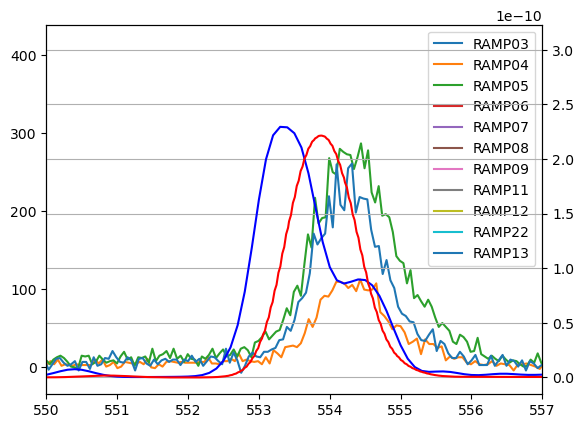

In [6]:
data_sets = [data03, data04, data05, data06, data07, data08, data09, data11, data12, data22, data13]
# data_sets = [data07, data03, data08]
fig = plt.figure()
ax1 = fig.gca()
for data in data_sets:
    ax1.plot(data.calibration_NEW2(),data.background_subtraction(), label = "RAMP"+data.name)
#     ax1.errorbar(data.calibration_NEW2(), data.background_subtraction(), yerr=np.abs(np.sqrt(data.data[:,7])), xerr=data.error_calibration_NEW2(), label = "RAMP"+data.name)
plt.legend()
ax2 = ax1.twinx()
ax2.plot(theory_n40_T32[:,0], theory_n40_T32[:,1], "b-", label = "FAC calc")
ax2.plot(theory_autostructure[:,0], theory_autostructure[:,1], "r-", label = "FAC calc")
# plt.xlim(433,437)
plt.xlim(550,557)
# plt.xlim(422,426)

plt.grid()
plt.show()

## to check the ion energy change

In [16]:
rev_freq=810665
beta_i=rev_freq *CIRC/C_LIGHT
print(beta_i/100, '%c')
gamma_i = np.sqrt(1.0/(1.0-beta_i*beta_i))
print(gamma_i)
E_i=(gamma_i-1)*(AMU_KG*C_LIGHT*C_LIGHT)*1e-6/ELEM_CHARGE
print(E_i,"MeV/u")
print('later from 10.1417 to 10.144 ->', E_i*10.144/10.1417, 'Mev/u')

0.0014609913664005519 %c
1.0108464284793772
10.103383559619909 MeV/u
later from 10.1417 to 10.144 -> 10.105674869970947 Mev/u


## RR peak
this analysis will give me a correct value for cooling energy

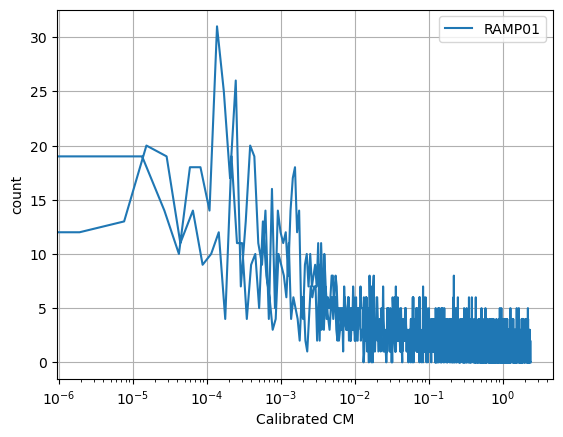

In [195]:
data=data01
fig = plt.figure()
ax1 = fig.gca()

ax1.plot(data.calibration_NEW2(), data.data[:,7], label = "RAMP"+data.name)
# ax1.plot(-data.calibraion_NEW2(), data.data[:,7], 'r',label = "RAMP"+data.name)
# plt.xlim(424,440)
# plt.xlim(425,425.1)
# plt.xlim(562,580)
# plt.xlim(540,545)
plt.legend()
plt.xlabel("Calibrated CM")
plt.ylabel("count")
# plt.ylim(-0.9e-10,0.9e-10)
plt.xscale('log')
plt.grid()
plt.show()
# plt.savefig("high.pdf")

9.662278799202795


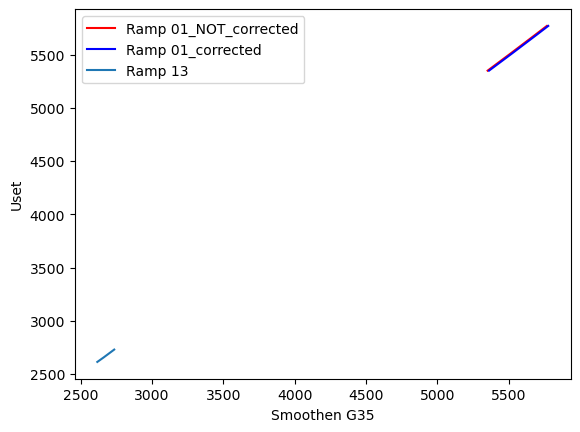

In [196]:
#Tego nie robie ale robilam wczesniej...
def find_best_A():
    # Extract x and y values from data13
    x13 = data13.data[300:, 0]
    y13 = data13.data[300:, 13] #g35
    def p(x):
        slope = 0.99769021
        intercept = 1.25130666
        return slope*x+intercept

    #take data from ramp01
    x_01 = data01.smoothen_G35()
    y_01 = data01.data[:,1]
    
    # Calculate corresponding y (RAMP 13) values using the fitted line
    y_range = p(x_01)

    # Find the best A value
    mse_list = []
    A_list = []
    for i in range(0,len(y_range)):
        A = y_01[i] - y_range[i]
        mse = ((y_01[i] - y_range[i]) ** 2).mean()
        mse_list.append(mse)
        A_list.append(A)
    best_A = A_list[np.argmin(mse_list)]
    #print(mse_list)
    return best_A

print(find_best_A())

# Plot the results
fig = plt.figure()
ax1 = fig.gca()
ax1.plot(data01.smoothen_G35(), data01.data[:,1],"r-", label = "Ramp "+"01_NOT_corrected")
ax1.plot(data01.smoothen_G35()+find_best_A(), data01.data[:,1],"b-", label = "Ramp "+"01_corrected")
ax1.plot(data13.smoothen_G35(), data13.data[:,1], label = "Ramp "+"13")
# ax1.plot(x_01, y_range, 'k--', label='Linear fit of Ramp 13')

# plt.xlim(5480, 5515)
# plt.ylim(5465,5500)
plt.xlabel("Smoothen G35")
plt.ylabel("Uset")
ax1.legend()
plt.show()

-0.005025125628140725


Text(0.5, 0.7, 'Center: -0.00000048')

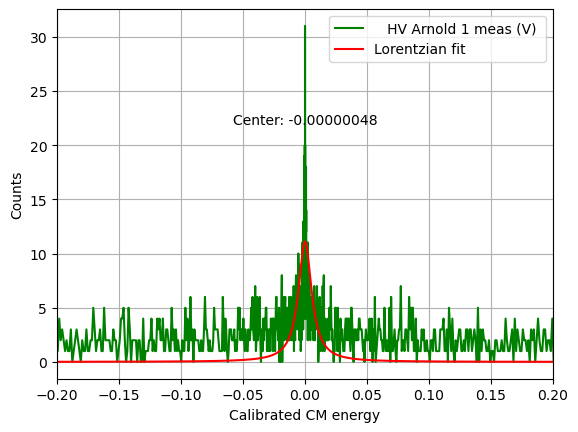

In [200]:
# Define the Lorentzian function
def lorentzian(x, x0, gamma, A):
    return A * (gamma**2) / ((x - x0)**2 + gamma**2)
# Calculate the differences between y1 and y2 for different translation values
translations = np.linspace(-1,1,200)#(15,15.2, 100)  # Adjust the range of translations if needed
possition_x0 = []
for translation in translations:
    # Extract the x and y data from your data01 array
    x = data01.calibration_LAB(translation)#+1.9455)
    y = data01.data[:,7]

    # Define the initial parameter values for the fit
    x0_init = np.mean(x)
    gamma_init = 1.0
    A_init = np.max(y)

    # Perform the fit using curve_fit
    popt, pcov = curve_fit(lorentzian, x, y, p0=[x0_init, gamma_init, A_init])

    # Extract the optimal parameter values from the fit
    x0_fit, gamma_fit, A_fit = popt
    possition_x0.append(x0_fit)
    
# Find the translation value that gives the closest match

best_translation = translations[np.argmin(np.abs(possition_x0))]
print(translations[np.argmin(np.abs(possition_x0))])
# Extract the x and y data from your data01 array
x = data01.calibration_LAB()#(best_translation)#+1.9455)
y = data01.data[:,7]

# Define the initial parameter values for the fit
x0_init = np.mean(x)
gamma_init = 1.0
A_init = np.max(y)

# Perform the fit using curve_fit
popt, pcov = curve_fit(lorentzian, x, y, p0=[x0_init, gamma_init, A_init])

# Extract the optimal parameter values from the fit
x0_fit, gamma_fit, A_fit = popt
possition_x0.append(x0_fit)
# Plot the original data and the fitted Lorentzian function
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, 'g-', label=data08.labels[13]+str(""))
ax.plot(x, lorentzian(x, x0_fit, gamma_fit, A_fit), 'r-', label='Lorentzian fit')
plt.grid()
ax.legend()
plt.xlabel("Calibrated CM energy")
plt.ylabel("Counts")
plt.xlim(-0.2,0.2)
#ax.set_xscale('log')

# Add a text label to show the center position
ax.text( 0.5,0.7,f'Center: {x0_fit:.8f}', ha='center', va='center', transform=ax.transAxes)

## to check the calibration again

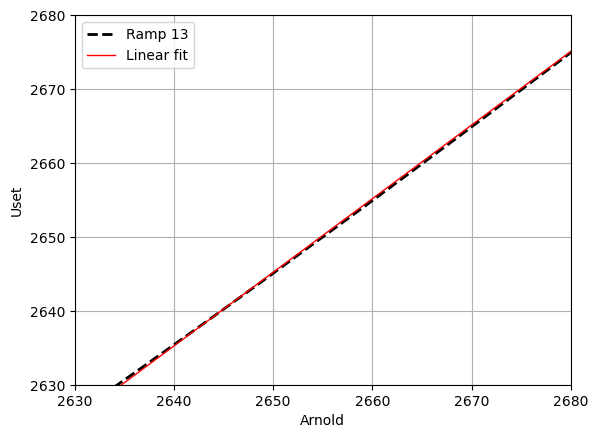

[0.9959626 5.9099861]


In [208]:
x_data13 = data13.smoothen_G35()
y_data13 = data13.data[:, 1]
# Mask the data below the threshold
mask = y_data13 >= 2625
x_data13_masked = x_data13[mask]
y_data13_masked = y_data13[mask]

# Perform linear fit to the masked data
coefficients = np.polyfit(x_data13_masked, y_data13_masked, 1)  # Linear fit (degree 1)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fit line
x_fit = np.linspace(min(x_data13_masked), max(x_data13_masked), 100)
y_fit = polynomial(x_fit)

# Create figure and axis
fig = plt.figure()
ax1 = fig.gca()

# Plot masked data13 with the fit line
ax1.plot(x_data13_masked, y_data13_masked, '--k', linewidth=2, label="Ramp " + data13.name)
ax1.plot(x_fit, y_fit, 'r-', linewidth=1, label="Linear fit")
# Labels and limits
plt.xlabel("Arnold")
plt.ylabel("Uset")
plt.xlim(2630, 2680)
plt.ylim(2630, 2680)

# Legend and grid
ax1.legend()
plt.grid()

# Show plot
plt.show()
print(coefficients)

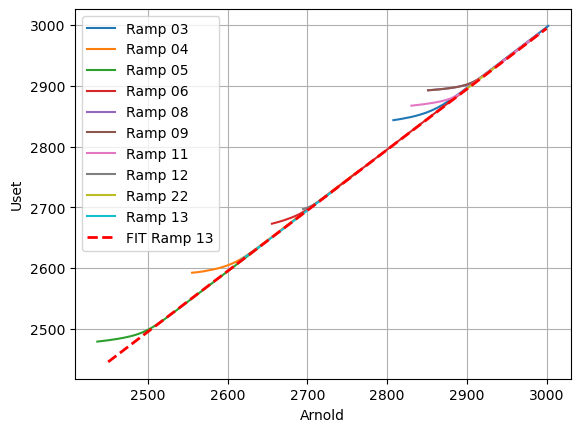

In [226]:
def fited_RAMP13(x):
    return 0.99769021*x+1.25130666

data_set=[data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
fig = plt.figure()
ax1 = fig.gca()

for data in data_set:
    ax1.plot(data.smoothen_G35(), data.data[:,1], label = "Ramp "+data.name)
#     ax1.plot(data.smoothen_G35(), data.calibration_LAB(), label = "Ramp "+data.name)
x_range = np.linspace(2450,3000,500)
y_range = fited_RAMP13(x_range)
ax1.plot(x_range, y_range,'--r',linewidth = '2', label = "FIT Ramp "+data13.name)
plt.xlabel("Arnold")
plt.ylabel("Uset")
# plt.xlim(2920, 3000)
# plt.ylim(2915,3000)
# plt.xlim(2640,2740)
# plt.ylim(2630,2740)
ax1.legend()
plt.grid()

## check the translations to ramp 13

In [17]:
# Assuming you have two datasets: x1, y1 and x2, y2
# x1 and x2 should cover the similar energy range
data=data05
# Generate sample data for two series of Lorenzian peaks
x1 = data13.smoothen_G35()
y1 = data13.background_subtraction()

x2 = data.smoothen_G35()
y2 = data.background_subtraction()

# Check and adjust the range of x2 if needed
x2_min = min(x2)
x2_max = max(x2)
desired_range = (min(x1), max(x1))

if x2_min < desired_range[0] or x2_max > desired_range[1]:
    # Truncate x2 and y2 to match the range of x1
    valid_indices = (x2 >= desired_range[0]) & (x2 <= desired_range[1])
    x2_new = x2[valid_indices]
    y2_new = y2[valid_indices]

# Downsample x2_new to match the resolution of x1 if needed
if len(x2_new) > len(x1):
    downsample_factor = int(len(x2_new) / len(x1))
    x2_downsampled = x2_new[::downsample_factor]
    y2_downsampled = y2_new[::downsample_factor]
else:
    x2_downsampled = x2_new
    y2_downsampled = y2_new

# Check and adjust the range of x1 if needed
if min(x1) < min(x2_downsampled) or max(x1) > max(x2_downsampled):
    valid_indices = (x1 >= min(x2_downsampled)) & (x1 <= max(x2_downsampled))
    x1_new = x1[valid_indices]
    y1_new = y1[valid_indices]
    
# Check and adjust the range of x2 if needed
# Check and adjust the range of x2 if needed
x2_min = min(x2_new)
x2_max = max(x2_new)
desired_range = (min(x1_new), max(x1_new))
if x2_min < desired_range[0] or x2_max > desired_range[1]:
    # Truncate x2 and y2 to match the range of x1
    valid_indices = (x2_new >= desired_range[0]) & (x2_new <= desired_range[1])
    x2_new = x2_new[valid_indices]
    y2_new = y2_new[valid_indices]
#else: leave how it is

# Interpolate y1_new onto the grid of x2_new
f = interp1d(x1_new, y1_new, kind='linear')
y1_aligned = f(x2_new)

# Define the fitting function
def translation_func(x, translation):
    return x + translation

# Perform the fitting
# Calculate the differences between y1 and y2 for different translation values
translations = np.linspace(-1, 1, 100000)  # Adjust the range of translations if needed
differences = []
for translation in translations:
    y2_aligned = np.interp(x1, x2_new + translation, y2_new)
    difference = np.sum(np.abs(y2_aligned - y1))
    differences.append(difference)

# Find the translation value that gives the closest match
best_translation = translations[np.argmin(differences)]

# Apply the best translation to x2_new
x2_aligned = x2_new + best_translation

# Plot the original series
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x1, y1, 'b-', label='Dataset 13')
plt.plot(x2, y2, 'r-', label='Dataset '+data.name)
plt.xlabel('Original x-axis')
plt.ylabel('Data')
plt.title('Original RAMPS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x1_new, y1_new, 'b-', label='Dataset 13')
plt.plot(x2_new, y2_new, 'r-', label='Dataset '+data.name)
plt.xlabel('Original x-axis')
plt.ylabel('Series 2')
plt.title('Original Series Trimmed')
plt.legend()

# Plot the transformed series
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x1_new, y1_new, 'b-', label='Dataset 13')
plt.plot(x2_new, y2_new, 'r-', label='Dataset '+data.name)
plt.plot(x2_aligned, y2_new, 'g-', label='Aligned Dataset 2')
# plt.xlim(2580,2590)
# plt.ylim(-10,60)
plt.xlabel('G35')
plt.ylabel('Data')
plt.title('Fitted: translation {:.6f}'.format(best_translation))

plt.legend()
plt.tight_layout()
plt.show()
print(best_translation)

## check the ACTrafo and IPM

### Ion current

$Ae^{-\lambda x} \approx A(1-\lambda x)$


# Status of analysis

/tmp/ipykernel_83987/2516033656.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  weights = [1/d**2 for d in bin_drates]
/tmp/ipykernel_83987/2516033656.py:49: RuntimeWarning: invalid value encountered in scalar divide
  sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights) #ERROR dividing by zero


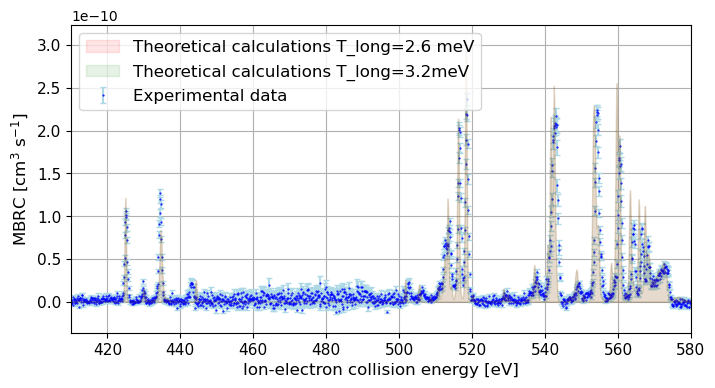

Written to file


In [8]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data03, data05, data12, data13]

# Initialize a list to store all combined data
rate_all=[]
energy_all=[]
drate_all=[]


# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    rate = dataset.rate_coef()
    drate = dataset.error_rate_coef()
    energy = dataset.calibration_NEW2()

    rate_all.append(rate)
    drate_all.append(drate)
    energy_all.append(energy)
    

# Flatten the lists of arrays into single 1D arrays
rate_all = np.concatenate(rate_all)
drate_all = np.concatenate(drate_all)
energies_all = np.concatenate(energy_all)

bins=np.arange(np.min(energies_all), np.max(energies_all), 0.1)#0.05)

#[j][k]
rate_binned = [[] for _ in range(len(bins)-1)]
drate_binned = [[] for _ in range(len(bins)-1)]
k=0
for i in range(len(energies_all)):
    for j in range(len(bins)-1):


        if bins[j] < energies_all[i] <= bins[j + 1]:
            rate_binned[j].append(rate_all[i])
            drate_binned[j].append(drate_all[i])

rate_avg=[]
drate_avg=[]


for bin_rates, bin_drates in zip(rate_binned, drate_binned):
    if bin_rates:  # Check if the bin is not empty
        weights = [1/d**2 for d in bin_drates]
        rate_avg.append(
            sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights) #ERROR dividing by zero
        )
        drate_avg.append(
            np.sqrt(1/sum(weights))
        )
    else:
        rate_avg.append(np.nan)
        drate_avg.append(np.nan)


energy_new=bins[:-1]
fig = plt.figure(figsize=(8, 4))
plt.errorbar(energy_new, rate_avg, drate_avg, linestyle='none', marker='.', markersize = 1, color='blue', ecolor='lightblue', capsize=2, label = "Experimental data")
plt.fill_between(theory_n40_T26[:, 0], theory_n40_T26[:, 1],color= "r", zorder=4, alpha=0.1, label = "Theoretical calculations T_long=2.6 meV")
# plt.fill_between(theory_n40_T29[:, 0], theory_n40_T29[:, 1],color= "b", zorder=3, alpha=0.1, label = "Theoretical calculations T_long=2.9 meV")
plt.fill_between(theory_n40_T32[:, 0], theory_n40_T32[:, 1],color= "g", zorder=5, alpha=0.1, label = "Theoretical calculations T_long=3.2meV")

# plt.title('The comparison of experimental and theoretical merged beam rate coefficient')
plt.xlabel('Ion-electron collision energy [eV]', fontsize = 12)
plt.ylabel('MBRC [cm$^3$ s$^{-1}$]', fontsize = 12)
plt.legend(loc='upper left', fontsize = 12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.xlim(410,580)
# plt.xlim(423,427)
# plt.xlim(549,580)
plt.show()
# plt.savefig("mbrc.png")



# with open(r'/u/wbielan/Documents/CodeWork/Oxygen_DR/dr_oxygen_analysis/input_data.dat', 'w') as fp:
#     for item1, item2 in zip(energy_new,rate_avg):
#         # write each item on a new line
#         if np.isnan(item2):
#             fp.write("%s %s\n" % (item1, 0))
#         else:
#             fp.write("%s %s\n" % (item1, item2))
#     print('Written to file')

## Plasma rate coefficient

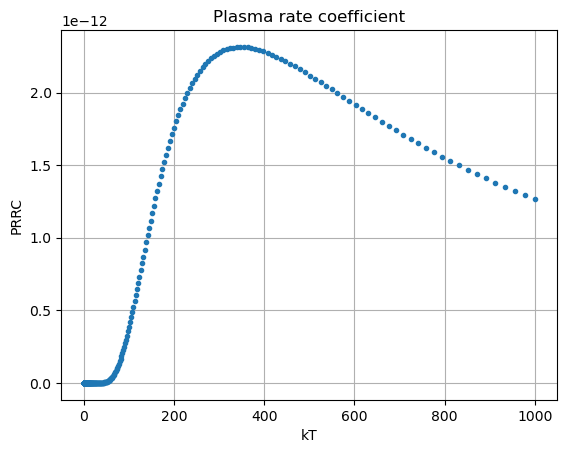

In [17]:
filename = "output_test.dat"

# Load data skipping the first two lines and reading only second and third columns
data = np.genfromtxt(filename, delimiter=None, skip_header=2, usecols=(1, 2))

# Separate the columns
second_column = data[:, 0]
third_column = data[:, 1]

# Plotting
plt.plot(second_column, third_column, 'o', markersize=3)
plt.xlabel('kT')
plt.ylabel('PRRC')
plt.title("Plasma rate coefficient")
plt.grid(True)
plt.show()

In [224]:
data_sets = [data03, data04, data05, data06, data07, data08, data09, data11, data12, data22, data13]
for data in data_sets:
    error_data = data.error_smoothen_G35()
    index_max = np.argmax(error_data)
    max_value=max(data.error_smoothen_G35())
    print(#data.smoothen_G35()[index_max],"\t", max(data.error_smoothen_G35()), "\t", index_max, "\n",
         "'",data.name,"'", ":", -data.calibration_NEW2()[index_max]+data.calibration_NEW2(max_value)[index_max],'/2,')
    for elem in data.error_calibration_NEW2():
        if elem <0: print("here", elem)
    #        data.error_calibration_NEW2())

' 03 ' : 0.4271392822265625 /2,
' 04 ' : 0.6035442352294922 /2,
' 05 ' : 0.8025779724121094 /2,
' 06 ' : 0.6848011016845703 /2,
' 07 ' : 0.8128738403320312 /2,
' 08 ' : 0.8881206512451172 /2,
' 09 ' : 3.493885040283203 /2,
' 11 ' : 1.5224647521972656 /2,
' 12 ' : 0.7375679016113281 /2,
' 22 ' : 0.505218505859375 /2,
' 13 ' : 0.570159912109375 /2,


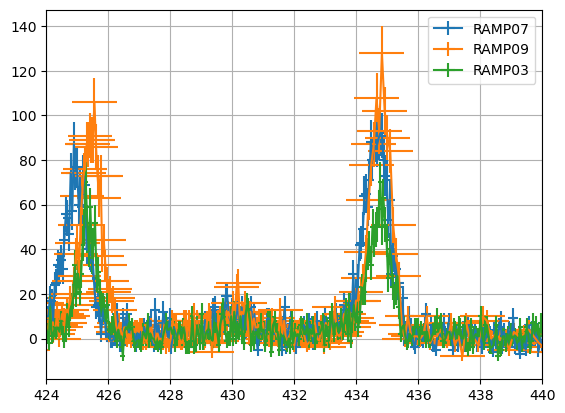

0.7491607666015625

In [225]:
# data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
data_sets = [data07,data09,data03]
# data_sets = [data04,data05, data13]
fig = plt.figure()
ax1 = fig.gca()
for data in data_sets:
#     ax1.plot(data.data[:,0],data.data[:,13], label = "RAMP"+data.name)
    ax1.errorbar(data.calibration_NEW2(), data.background_subtraction(), yerr=np.abs(np.sqrt(data.data[:,7])), xerr=data.error_calibration_NEW2(), label = "RAMP"+data.name)
plt.xlim(424,440)
# plt.xlim(525,532)
# plt.xlim(545,560)
# plt.xlim(541,544)
# plt.xlim(127,130)
plt.legend()
plt.grid()
plt.show()
max(data09.error_calibration_NEW2())


## beam temperature

## $k_bT_{long} = w_G^2 / (16 ln2 E_{res})$
beamcalc 0.05 meV
## $k_bT_{perp} = w_G / ln2$
beamcalc 3.2 meV

FWHM 0.35286267903809526 
 Fitted parameters: [ 4.25114332e+02  3.52862679e-01  4.18517805e-02  1.43405406e+02
 -3.72796228e+00] 
 K_bT_{long}= 0.026409505146392055 meV K_bT_{perp}= 509.0732371630541 meV


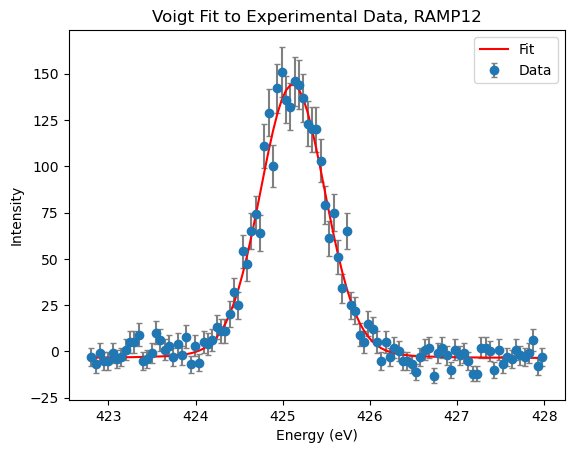

In [72]:
data = data22
T_list = []

# Define the Voigt profile function, sigma is a gaussian width
def voigt_profile(x, x0, sigma, gamma, A, B):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + B

# Define the residuals function
def residuals(params, x, y, yerr):
    x0, sigma, gamma, A, B = params
    return (y - voigt_profile(x, x0, sigma, gamma, A, B)) / yerr

# Load your data
data = data22  # Assuming data22 is defined elsewhere
x_data = data.calibration_NEW2()
y_data = data.background_subtraction()
yerr = np.abs(np.sqrt(data.data[:, 7]))

# Filter the data to keep only energies between 420 and 428
mask = (x_data >= 420) & (x_data <= 428)
x_filtered = x_data[mask]
y_filtered = y_data[mask]
yerr_filtered = yerr[mask]

# Initial guess for the parameters
initial_guess = [424, 0.6, 0.1, 0.2, 0.01]  # [x0, sigma, gamma, A, B]
# Set bounds for the parameters to enforce positive gamma
bounds = ([422, 0, 0, 0, -np.inf], [426, np.inf, np.inf, np.inf, np.inf])  # [min, max] for each parameter

# Perform the least squares fitting
result = opt.least_squares(residuals, initial_guess, args=(x_filtered, y_filtered, yerr_filtered), bounds=bounds)



# Extract the best-fit parameters
fitted_params = result.x
w_G = fitted_params[1]#*2*np.sqrt(2*np.log(2))
temp_long = w_G**2/(16*np.log(2)*fitted_params[0])
temp_perp = w_G/np.log(2)

print("FWHM", w_G, '\n', "Fitted parameters:", fitted_params, '\n', 'K_bT_{long}=', temp_long* 1e3, 'meV', 'K_bT_{perp}=', temp_perp* 1e3, 'meV')

# Plot the resuls
plt.figure()
plt.errorbar(x_filtered, y_filtered, yerr=yerr_filtered, fmt='o', label='Data', ecolor='gray', capsize=2)
plt.plot(x_filtered, voigt_profile(x_filtered, *fitted_params), label='Fit', color='red')
plt.title('Voigt Fit to Experimental Data, RAMP'+data.name)
plt.xlabel('Energy (eV)')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [75]:
data_set = [data03, data08, data09, data22] #data11
T_list = []

# Define the Voigt profile function, sigma is a gaussian width
def voigt_profile(x, x0, sigma, gamma, A, B):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + B

# Define the residuals function
def residuals(params, x, y, yerr):
    x0, sigma, gamma, A, B = params
    return (y - voigt_profile(x, x0, sigma, gamma, A, B)) / yerr
for data in data_set:
    # Load your data
    x_data = data.calibration_NEW2()
    y_data = data.background_subtraction()
    yerr = np.abs(np.sqrt(data.data[:, 7]))

    # Filter the data to keep only energies between 420 and 428
    mask = (x_data >= 420) & (x_data <= 428)
    x_filtered = x_data[mask]
    y_filtered = y_data[mask]
    yerr_filtered = yerr[mask]

    # Initial guess for the parameters
    initial_guess = [424, 0.6, 0.1, 0.2, 0.01]  # [x0, sigma, gamma, A, B]
    # Set bounds for the parameters to enforce positive gamma
    bounds = ([422, 0, 0, 0, -np.inf], [426, np.inf, np.inf, np.inf, np.inf])  # [min, max] for each parameter

    # Perform the least squares fitting
    result = opt.least_squares(residuals, initial_guess, args=(x_filtered, y_filtered, yerr_filtered), bounds=bounds)



    # Extract the best-fit parameters
    fitted_params = result.x
    w_G = fitted_params[1]*2*np.sqrt(2*np.log(2))
    temp_perp = w_G/np.log(2)
    temp_long = w_G**2/(16*np.log(2)*fitted_params[0])
    print("RAMP", data.name, "\t", 'K_bT_{long}=', temp_long* 1e3, 'meV', 'K_bT_{perp}=', temp_perp* 1e3, 'meV')



RAMP 03 	 K_bT_{long}= 0.09554683619843361 meV K_bT_{perp}= 968.2778119579264 meV
RAMP 08 	 K_bT_{long}= 0.1294398920566553 meV K_bT_{perp}= 1127.0152887961276 meV
RAMP 09 	 K_bT_{long}= 0.08626574200975391 meV K_bT_{perp}= 920.0516578501852 meV
RAMP 12 	 K_bT_{long}= 0.1464453922576401 meV K_bT_{perp}= 1198.775863260354 meV


FWHM 0.9108159863289074 
 Fitted parameters: [5.54312342e+02 3.86787937e-01 2.21592528e-01 1.57734620e+02
 8.62671546e-01] 
 K_bT_long= 0.13494639816731127 meV K_bT_perp= 1314.0297066391047 meV


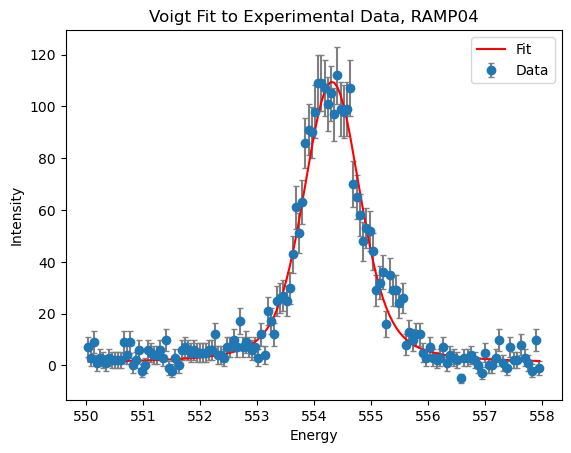

In [14]:
data = data04
T_list = []

# Define the Voigt profile function, sigma is a gaussian width
def voigt_profile(x, x0, sigma, gamma, A, B):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + B

# Define the residuals function
def residuals(params, x, y, yerr):
    x0, sigma, gamma, A, B = params
    return (y - voigt_profile(x, x0, sigma, gamma, A, B)) / yerr

# Load your data
x_data = data.calibration_NEW2()
y_data = data.background_subtraction()
yerr = np.abs(np.sqrt(data.data[:, 7]))

# Filter the data to keep only energies between 420 and 428
mask = (x_data >= 550) & (x_data <= 558)
x_filtered = x_data[mask]
y_filtered = y_data[mask]
yerr_filtered = yerr[mask]

# Initial guess for the parameters
initial_guess = [555, 0.6, 0.1, 0.2, 0.01]  # [x0, sigma, gamma, A, B]
# Set bounds for the parameters to enforce positive gamma
bounds = ([552, 0, 0, 0, -np.inf], [558, np.inf, np.inf, np.inf, np.inf])  # [min, max] for each parameter

# Perform the least squares fitting
result = opt.least_squares(residuals, initial_guess, args=(x_filtered, y_filtered, yerr_filtered), bounds=bounds)



# Extract the best-fit parameters
fitted_params = result.x

w_G = fitted_params[1]*2*np.sqrt(2*np.log(2))
temp_long = w_G**2/(16*np.log(2)*fitted_params[0])
temp_perp = w_G/np.log(2)

print("FWHM", w_G, '\n', "Fitted parameters:", fitted_params, '\n', 'K_bT_long=', temp_long* 1e3, 'meV', 'K_bT_perp=', temp_perp* 1e3, 'meV')


# Plot the results
plt.figure()
plt.errorbar(x_filtered, y_filtered, yerr=yerr_filtered, fmt='o', label='Data', ecolor='gray', capsize=2)
plt.plot(x_filtered, voigt_profile(x_filtered, *fitted_params), label='Fit', color='red')
plt.title('Voigt Fit to Experimental Data, RAMP'+data.name)
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.legend()
plt.show()

FWHM 0.48741089019491907 
 Fitted parameters: [4.24896321e+02 2.06984347e-01 1.39534354e-02 6.63354734e+01
 1.07144708e-01] 
 K_bT_long= 0.050415263632840095 meV K_bT_perp= 703.1852741594848 meV


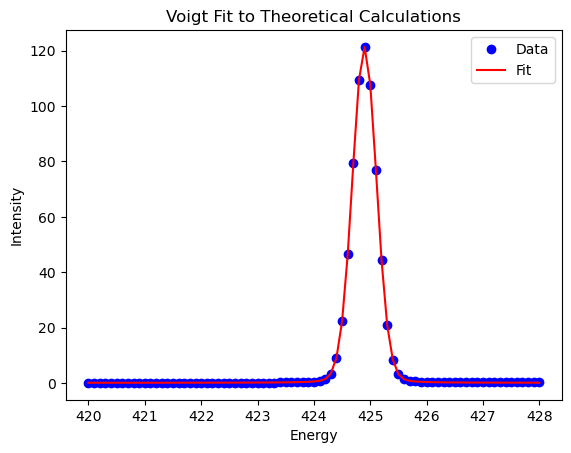

In [12]:
# Given data
data = theory_n40_T32


# Define the Voigt profile function, sigma is a gaussian width
def voigt_profile(x, x0, sigma, gamma, A, B):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + B

# Define the residuals function
def residuals(params, x, y):
    x0, sigma, gamma, A, B = params
    return y - voigt_profile(x, x0, sigma, gamma, A, B)

# Load your data
x_data = data[:, 0]
y_data = data[:, 1]*1e12

# Filter the data to keep only energies between 420 and 428
mask = (x_data >= 420) & (x_data <= 428)
x_filtered = x_data[mask]
y_filtered = y_data[mask]

# Initial guess for the parameters
initial_guess = [425, 0.3, 0.1, 143, 0]  # [x0, sigma, gamma, A, B]

# Set bounds for the parameters to enforce positive gamma
bounds = ([422, 0, 0, 0, -np.inf], [426, np.inf, np.inf, np.inf, np.inf])  # [min, max] for each parameter

# Perform the least squares fitting
result = opt.least_squares(residuals, initial_guess, args=(x_filtered, y_filtered), bounds=bounds)

# Extract the best-fit parameters
fitted_params = result.x

w_G = fitted_params[1]*2*np.sqrt(2*np.log(2))
temp_long = w_G**2/(16*np.log(2)*fitted_params[0])
temp_perp = w_G/np.log(2)

print("FWHM", w_G, '\n', "Fitted parameters:", fitted_params, '\n', 'K_bT_long=', temp_long* 1e3, 'meV', 'K_bT_perp=', temp_perp* 1e3, 'meV')

# Plot the results
plt.figure()
plt.plot(x_filtered, y_filtered, 'o', label='Data', color='blue')
plt.plot(x_filtered, voigt_profile(x_filtered, *fitted_params), label='Fit', color='red')
plt.title('Voigt Fit to Theoretical Calculations')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# $\alpha = \frac{count/time { } \cdot \gamma_i^2}{n_eN_iL/C}$

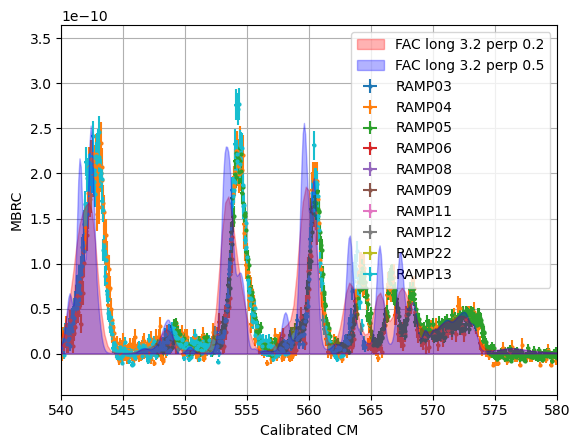

In [17]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data03, data11]
# data_sets = [data03, data08, data09, data11, data22]
# data_sets = [data04, data05, data06, data12, data13]
fig = plt.figure()
ax1 = fig.gca()
for data in data_sets:
    ax1.errorbar(data.calibration_NEW2(), data.rate_coef(), data.error_rate_coef(), data.error_calibration_NEW2(), marker='o', markersize=2, linestyle='', label = "RAMP"+data.name)
ax1.fill_between(theory_n40_T32_02[:, 0], theory_n40_T32_02[:, 1],color= "r", label="FAC long 3.2 perp 0.2", zorder=10, alpha=0.3)
ax1.fill_between(theory_n40_T32[:, 0], theory_n40_T32[:, 1],color= "b", label="FAC long 3.2 perp 0.05", zorder=11, alpha=0.3)
plt.xlim(424,440)
# plt.xlim(425,425.1)
plt.xlim(540,580)
# plt.xlim(540,545)
plt.legend()
plt.xlabel("Calibrated CM")
plt.ylabel("MBRC")
# plt.ylim(-0.9e-10,0.9e-10)
plt.grid()
plt.show()
# plt.savefig("high.pdf")

/tmp/ipykernel_3289683/19443500.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  weights = [1/d**2 for d in bin_drates]
/tmp/ipykernel_3289683/19443500.py:49: RuntimeWarning: invalid value encountered in scalar divide
  sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights) #ERROR dividing by zero


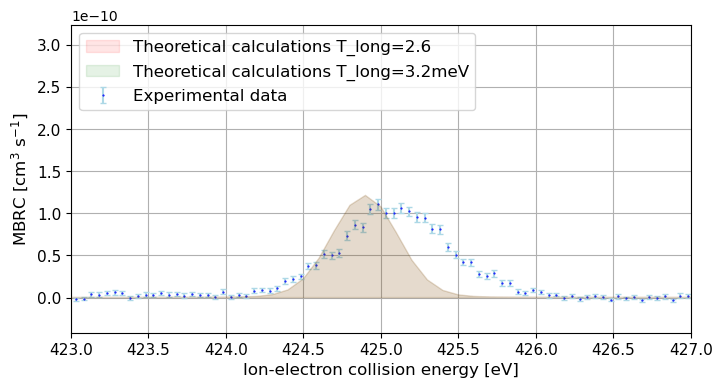

In [39]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]
# data_sets = [data08]

# Initialize a list to store all combined data
rate_all=[]
energy_all=[]
drate_all=[]


# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    rate = dataset.rate_coef()
    drate = dataset.error_rate_coef()
    energy = dataset.calibration_NEW2()

    rate_all.append(rate)
    drate_all.append(drate)
    energy_all.append(energy)
    

# Flatten the lists of arrays into single 1D arrays
rate_all = np.concatenate(rate_all)
drate_all = np.concatenate(drate_all)
energies_all = np.concatenate(energy_all)

bins=np.arange(np.min(energies_all), np.max(energies_all), 0.05)

#[j][k]
rate_binned = [[] for _ in range(len(bins)-1)]
drate_binned = [[] for _ in range(len(bins)-1)]
k=0
for i in range(len(energies_all)):
    for j in range(len(bins)-1):


        if bins[j] < energies_all[i] <= bins[j + 1]:
            rate_binned[j].append(rate_all[i])
            drate_binned[j].append(drate_all[i])

rate_avg=[]
drate_avg=[]


for bin_rates, bin_drates in zip(rate_binned, drate_binned):
    if bin_rates:  # Check if the bin is not empty
        weights = [1/d**2 for d in bin_drates]
        rate_avg.append(
            sum(r*w for r, w in zip(bin_rates, weights)) / sum(weights) #ERROR dividing by zero
        )
        drate_avg.append(
            np.sqrt(1/sum(weights))
        )
    else:
        rate_avg.append(np.nan)
        drate_avg.append(np.nan)


energy_new=bins[:-1]
fig = plt.figure(figsize=(8, 4))
plt.errorbar(energy_new, rate_avg, drate_avg, linestyle='none', marker='.', markersize = 1, color='blue', ecolor='lightblue', capsize=2, label = "Experimental data")
plt.fill_between(theory_n40_T26[:, 0], theory_n40_T26[:, 1],color= "r", zorder=4, alpha=0.1, label = "Theoretical calculations T_long=2.6")
# plt.fill_between(theory_n40_T29[:, 0], theory_n40_T29[:, 1],color= "b", zorder=3, alpha=0.1, label = "Theoretical calculations T_long=2.9 meV")
plt.fill_between(theory_n40_T32[:, 0], theory_n40_T32[:, 1],color= "g", zorder=5, alpha=0.1, label = "Theoretical calculations T_long=3.2meV")

# plt.title('The comparison of experimental and theoretical merged beam rate coefficient')
plt.xlabel('Ion-electron collision energy [eV]', fontsize = 12)
plt.ylabel('MBRC [cm$^3$ s$^{-1}$]', fontsize = 12)
plt.legend(loc='upper left', fontsize = 12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.xlim(410,580)
plt.xlim(423,427)
plt.show()
# plt.savefig("mbrc.png")

## Histograms

I am dividing by sum of N_i and n_e 

In [11]:
data04.Edensity(dataset.calibration_LAB())*1e-6

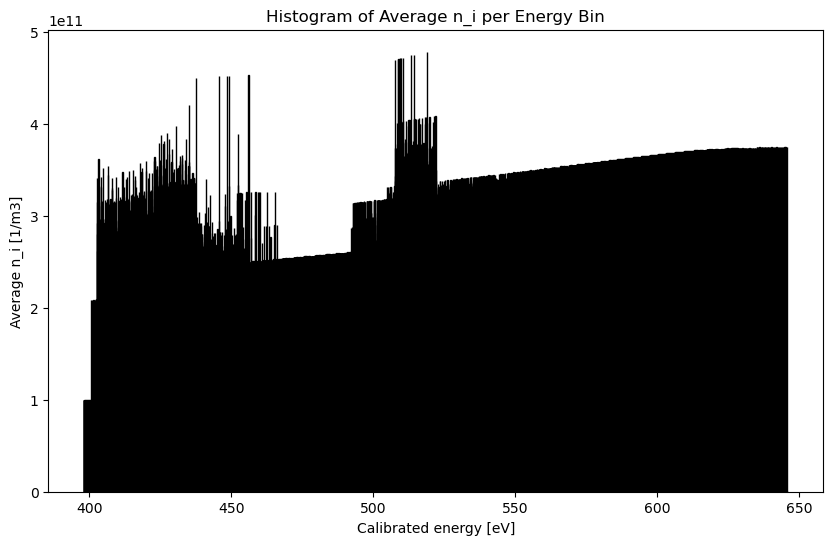

In [57]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)


# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)


# Calculate histogram of sums
hist_sum, _ = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all)

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Calculate the average weights
hist_avg = hist_sum / hist_count

# Handle NaNs if any bins had zero entries
hist_avg = np.nan_to_num(hist_avg, nan=0.0)
# hist_avg = np.nan_to_num(hist_sum, nan=0.0)

# Create the plot
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
ax.bar(bin_centers, hist_avg, width=np.diff(bin_edges), align='center', edgecolor='black')
ax.set_xlabel('Calibrated energy [eV]')
ax.set_ylabel('Average n_i [1/m3]')
ax.set_title('Histogram of Average n_i per Energy Bin')
# plt.xlim(425,425.1)
plt.show()

/tmp/ipykernel_2463585/2682601109.py:37: RuntimeWarning: invalid value encountered in divide
  return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6)
/tmp/ipykernel_2463585/2682601109.py:65: RuntimeWarning: invalid value encountered in sqrt
  ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, hist_n_ion/hist_count, hist_n_e/(hist_count)), yerr=rate_coef(np.sqrt(hist), hist_time, hist_gamma_e/hist_count, hist_n_ion/hist_count, hist_n_e/hist_count), fmt='-', color='black', ecolor='gray', label='Measured Data')


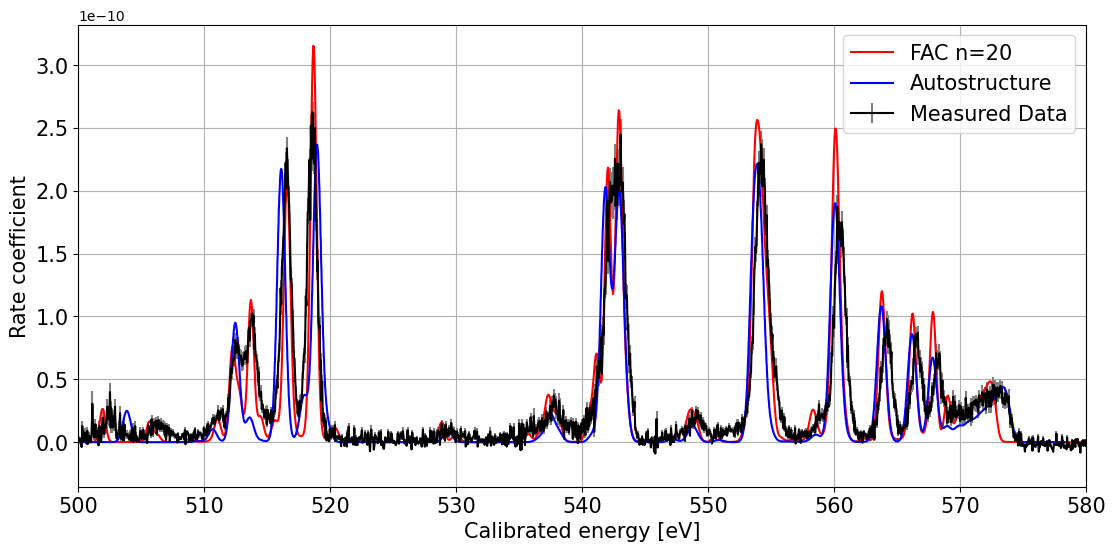

[ 2.  1.  1. ... nan nan nan]


<Figure size 640x480 with 0 Axes>

In [190]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)

def rate_coef(count, time, gamma, n_ion, n_e):
    return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6) 

# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)

# Compute histogram
hist, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=data_all)

hist_time, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=time_all )
hist_n_ion, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all) 
hist_n_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=n_e_all) 
hist_gamma_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=gamma_e_all) 

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Calculate the bin centers from the bin edges
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

# Plot histogram with error bars
# ax1.errorbar(bin_centers, (hist/hist_time)* hist_gamma_e**2 / (ETA * hist_n_ion * 1e-6 * hist_n_e * 1e-6) , fmt='-', color='black')
# hist_gamma_e/hist_count
ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, hist_n_ion/hist_count, hist_n_e/(hist_count)), yerr=rate_coef(np.sqrt(hist), hist_time, hist_gamma_e/hist_count, hist_n_ion/hist_count, hist_n_e/hist_count), fmt='-', color='black', ecolor='gray', label='Measured Data')

# Additional theoretical curves
ax1.plot(theory_n20[:, 0], theory_n20[:, 1], "r-", label="FAC n=20")
ax1.plot(theory_autostructure[:, 0], theory_autostructure[:, 1], "b-", label="Autostructure")

ax1.set_xlabel('Calibrated energy [eV]', fontsize=15)
ax1.set_ylabel('Rate coefficient', fontsize=15)
plt.grid()
ax1.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)

# Display the plot
plt.xlim(410,580)
plt.xlim(420,450)
# plt.xlim(515,518)
# plt.xlim(500,535)
plt.xlim(500,580)

# plt.ylim(-0.1e-10,5e-10)

plt.show()
# plt.savefig("hist_high.pdf")
print(hist_count)

Lets now assume constant n_e N_i and gamma=1

In [14]:
data_sets = [data03, data04, data05, data06, data08, data09, data11, data12, data22, data13]

# Initialize a list to store all combined data
data_all=[]
energy_all=[]
time_all=[]
N_ion_all=[]
n_e_all=[]
gamma_e_all=[]

# Iterate over each dataset and collect the data
for dataset in data_sets:
    # Assuming each dataset has a method called `get_raw_data()` that returns the data as an array
    data = dataset.background_subtraction()
    energy = dataset.calibration_NEW2()
    time = dataset.data[:,37]
    N_ion = dataset.N_ion()
    n_e = dataset.Edensity(dataset.calibration_LAB())
    gamma_e = (MASS_E + dataset.calibration_LAB()) / MASS_E
    # Append data to the combined list
    data_all.append(data)
    energy_all.append(energy)
    time_all.append(time)
    N_ion_all.append(N_ion)
    n_e_all.append(n_e)
    gamma_e_all.append(gamma_e)

# Flatten the lists of arrays into single 1D arrays
data_all = np.concatenate(data_all)
energies_all = np.concatenate(energy_all)
time_all = np.concatenate(time_all)
N_ion_all = np.concatenate(N_ion_all)
n_e_all = np.concatenate(n_e_all)
gamma_e_all = np.concatenate(gamma_e_all)

def rate_coef(count, time, gamma, n_ion, n_e):
    return (count / time) * gamma**2 / (ETA * n_ion* 1e-6 * n_e * 1e-6) 

# Define your bins
bin_edges = np.arange(np.min(energies_all), np.max(energies_all), 0.05)

# Compute histogram
hist, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=data_all)

hist_time, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=time_all )
hist_n_ion, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=N_ion_all) #NOT!
hist_n_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=n_e_all) #NOT!
hist_gamma_e, bin_edges = np.histogram(energies_all, bins=bin_edges, weights=gamma_e_all) #NOT!

# Calculate histogram of counts
hist_count, _ = np.histogram(energies_all, bins=bin_edges)

# Avoid division by zero
hist_count = np.where(hist_count == 0, np.nan, hist_count)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Calculate the bin centers from the bin edges
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

# Plot histogram with error bars
# ax1.errorbar(bin_centers, (hist/hist_time)* hist_gamma_e**2 / (ETA * hist_n_ion * 1e-6 * hist_n_e * 1e-6) , fmt='-', color='black')
# hist_gamma_e/hist_count
ax1.errorbar(bin_centers, rate_coef(hist, hist_time, 1, 1.4e11 ,1e13), yerr=rate_coef(np.sqrt(hist), hist_time, 1, 1.4e11 ,1e13), fmt='-', color='black', ecolor='gray', label='Measured Data')

# Additional theoretical curves
ax1.plot(theory_n20[:, 0], theory_n20[:, 1], "r-", label="FAC n=20")
ax1.plot(theory_autostructure[:, 0], theory_autostructure[:, 1], "b-", label="Autostructure")

ax1.set_xlabel('Calibrated energy [eV]', fontsize=15)
ax1.set_ylabel('Rate coefficient', fontsize=15)
plt.grid()
ax1.tick_params(axis='both', labelsize=15)
plt.legend(loc='upper right', fontsize=15)

# Display the plot
plt.xlim(410,580)
plt.xlim(420,450)
# plt.xlim(515,518)
# plt.xlim(500,535)
# plt.xlim(535,580)

# plt.ylim(-0.1e-10,5e-10)

plt.show()
print(hist_count)

To check smoothness :)

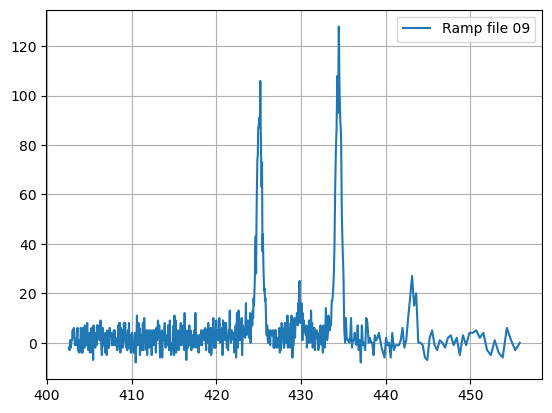

In [317]:
ax1 = plt.subplot()


# ax1.scatter(data03.calibration_NEW2(), data03.background_subtraction(), s=2, label = "Ramp file 03")
# ax1.scatter(data04.calibration_NEW2(), data04.background_subtraction(), label = "Ramp file 04")
# ax1.plot(data05.calibration_NEW2(), data05.background_subtraction(), label = "Ramp file 05")
# ax1.plot(data06.calibration_NEW2(), data06.background_subtraction(), label = "Ramp file 06")
# ax1.plot(data07.calibration_NEW2(), data07.background_subtraction(), label = "Ramp file 07")
# ax1.plot(data08.calibration_NEW2(), data08.background_subtraction(), label = "Ramp file 08")
ax1.plot(data09.calibration_NEW2(), data09.background_subtraction(), label = "Ramp file 09")
# ax1.plot(data11.calibration_NEW2(), data11.background_subtraction(), label = "Ramp file 11")
# ax1.plot(data22.calibration_NEW2(), data22.background_subtraction(), 'r-', label = "Ramp file 12")# lower energy")
# ax1.plot(data12.calibration_NEW2(), data12.background_subtraction(), 'g-', label = "Ramp file 12") #higher energy
# ax1.scatter(data13.calibration_NEW2(), data13.background_subtraction(), label = "Ramp file 13")
plt.grid()



#plt.xlim(2570,2650)
# plt.xlim(512, 513)
# plt.xlim(412,413)
# plt.ylim(-10,20)
ax1.legend(fontsize=10)